In [1]:
import pymc as pm
import numpy as np
from matplotlib import pyplot as plt
import arviz as az
from astropy.table import Table

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


['group', 'xobs', 'xerr', 'xtrue', 'yobs', 'yerr', 'ytrue']
group         xobs         ...         yerr               ytrue        
----- -------------------- ... ------------------- --------------------
    0   -0.843891677727065 ... 0.08903323690028672  -0.5241312128480028
    0    2.208213490335025 ... 0.08399020526585921   1.7710145128460575
    0  -1.3338611623966337 ... 0.09815496714103776   -1.067402497752652
    0  -0.5393708033279396 ... 0.08359065033737394  -0.5154371635532665
    0 -0.05076079701375139 ... 0.10363928627638373 0.010156081422008226
    0    1.121151077152531 ... 0.10231443655279523   0.9931764908698113
    0   0.3118313861036259 ... 0.09468439615504974   0.4103534030022189
    0   1.0786917020298232 ... 0.12385659279015027   0.6899215034264476
    0   1.0671174123543308 ... 0.10232090668451756   0.5123556019105513
    0   0.7378292712323296 ... 0.09775657083361756   0.6612885053098586


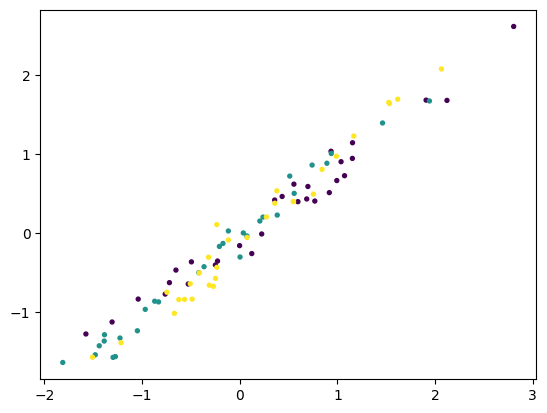

In [3]:
data = Table.read( 'example_data_for_pymc.fits' )
print( data.colnames )

print( data[:10] )
plt.clf()
plt.scatter( data['xtrue'], data['yobs'], 8, data['group'] )


In [5]:
# fit the full ensemble as one
xdata, xerr = data['xtrue'], 0.
ydata, yerr = data['yobs'], data['yerr']

# Define the model
with pm.Model() as model_pooled :
    # Priors for unknown model parameters
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    slope = pm.Normal('slope', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
    # Expected value of outcome
    ymodel = intercept + slope * xdata
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=ymodel, tau=1./(sigma**2.+yerr**2), observed=ydata)
    

In [6]:
with model_pooled :
    # Sample from the posterior
    trace_pooled = pm.sample(200, tune=100, return_inferencedata=True)

# Print summary statistics
print(az.summary(trace_pooled, var_names=['intercept', 'slope', 'sigma']))

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 100 tune and 200 draw iterations (400 + 800 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
intercept -0.080  0.019  -0.113   -0.043      0.001    0.000    1174.0  \
slope      0.967  0.020   0.930    1.003      0.001    0.000    1205.0   
sigma      0.142  0.015   0.114    0.168      0.001    0.001     136.0   

           ess_tail  r_hat  
intercept     546.0   1.01  
slope         562.0   1.00  
sigma         204.0   1.03  


In [7]:
print( dir( trace_pooled ) )
print( trace_pooled.observed_data )


['InferenceDataItemsView', 'InferenceDataValuesView', '__abstractmethods__', '__add__', '__annotations__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_attrs', '_group_names', '_groups', '_groups_all', '_groups_warmup', '_is_protocol', '_repr_html_', '_wrap_xarray_method', 'add_groups', 'assign', 'assign_coords', 'attrs', 'chunk', 'compute', 'copy', 'cumsum', 'extend', 'from_datatree', 'from_netcdf', 'from_zarr', 'get', 'get_index', 'groups', 'isel', 'items', 'keys', 'load', 'map', 'max', 'mean', 'median', 'mi

In [8]:
# now fit each group simultaneously but independently
xdata, xerr = data['xtrue'], 0.
ydata, yerr = data['yobs'], data['yerr']

group_names, group_indices = np.unique( data['group'], return_inverse=True )
group_dict = { gid : np.where( data['group'] == gid )[0] for gid in group_names }
num_models = np.size( np.unique( data['group'] ) )
print( f'num_models = {num_models}')
print( group_indices )

print( 'number of points per group:', np.unique(data['group'], return_counts=True) )

with pm.Model() as model_parallel :
    
    # Priors for unknown model parameters
    intercept = pm.Normal('intercept', mu=0, sigma=5, shape=num_models )                            
    slope = pm.Normal('slope', mu=0, sigma=5, shape=num_models )                              
    sigma = pm.Exponential('sigma', lam=1, shape=num_models )
    # nb. use shape to specify number of each of these parameters
    
    # Expected value of outcome
    ymodel = intercept[ group_indices ] + slope[ group_indices ] * xdata
    tau = 1./( sigma[group_indices]**2. + yerr**2 )
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=ymodel, tau=tau, observed=ydata)
    

num_models = 3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
number of points per group: (<MaskedColumn name='group' dtype='int64' length=3>
0
1
2, array([30, 30, 30], dtype=int64))


In [9]:
with model_parallel :
    # Sample from the posterior
    trace_parallel = pm.sample(1500, tune=1000, 
                               discard_tuned_samples=True,
                               return_inferencedata=True )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 700 seconds.


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
intercept[0] -0.057  0.032  -0.116    0.004      0.000      0.0    6779.0  \
intercept[1] -0.047  0.027  -0.101    0.002      0.000      0.0    7188.0   
intercept[2] -0.111  0.030  -0.169   -0.056      0.000      0.0    7158.0   
slope[0]      0.868  0.031   0.807    0.924      0.000      0.0    7145.0   
slope[1]      0.993  0.027   0.945    1.047      0.000      0.0    6640.0   
slope[2]      1.090  0.036   1.018    1.153      0.000      0.0    7148.0   
sigma[0]      0.127  0.029   0.077    0.184      0.000      0.0    6665.0   
sigma[1]      0.090  0.032   0.033    0.153      0.001      0.0    2636.0   
sigma[2]      0.128  0.030   0.076    0.186      0.000      0.0    5588.0   

              ess_tail  r_hat  
intercept[0]    4592.0    1.0  
intercept[1]    4926.0    1.0  
intercept[2]    4909.0    1.0  
slope[0]        4507.0    1.0  
slope[1]        4782.0    1.0  
slope[2]        4231.0    1.0  
sigma

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

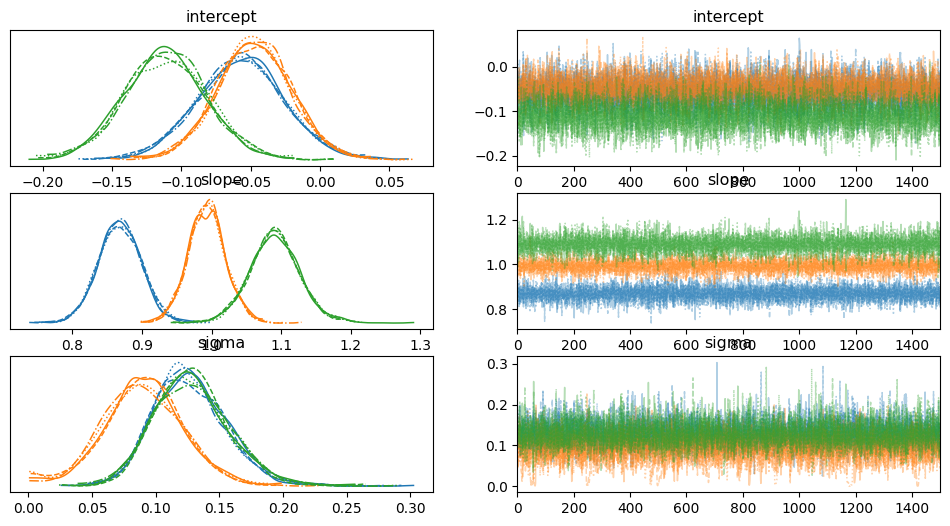

In [10]:
# Print summary statistics
print( az.summary(trace_parallel) )#, var_names=['intercept', 'slope', 'sigma']))

az.plot_trace( trace_parallel )

In [87]:
# now try a fully hierarchical approach
xdata, xerr = data['xtrue'], 0.
ydata, yerr = data['yobs'], data['yerr']

group_names, group_indices = np.unique( data['group'], return_inverse=True )
group_dict = { gid : np.where( data['group'] == gid )[0] for gid in group_names }
num_models = np.size( np.unique( data['group'] ) )
print( f'num_models = {num_models}')
print( group_indices )

with pm.Model() as model_hierarch :
    # Priors for the hyperparameters 
    group_intercept_mean = pm.Normal( 'group_intercept_mean', mu=0, sigma=2 )
    group_intercept_stddev = pm.Exponential( 'group_intercept_stddev', lam=1 )

    group_slope_mean = pm.Normal( 'group_slope_mean', mu=0, sigma=2 )
    group_slope_stddev = pm.Exponential( 'group_slope_stddev', lam=1 )
    
    # Priors for unknown model parameters
    intercept = pm.Normal('intercept', 
                          mu=group_intercept_mean, 
                          sigma=group_intercept_stddev, 
                          shape=num_models)
    slope = pm.Normal('slope', 
                      mu=group_slope_mean, 
                      sigma=group_slope_stddev, 
                      shape=num_models)
    sigma = pm.Exponential('sigma', 
                          lam=1, 
                          shape=num_models )
    # nb. use shape to specify number of each of these parameters
    
    # Expected value of outcome
    ymodel = intercept[ group_indices ] + slope[ group_indices ] * xdata
    tau = 1./( sigma[group_indices]**2. + yerr**2 )
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=ymodel, tau=tau, observed=ydata)
    

num_models = 11
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  

In [89]:
with model_hierarch :
    # Sample from the posterior
    trace_hierarch = pm.sample(1500, tune=1000, 
                               target_accept=0.98,
                               discard_tuned_samples=True,
                               return_inferencedata=True )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_intercept_mean, group_intercept_stddev, group_slope_mean, group_slope_stddev, intercept, slope, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 97 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.


                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
group_intercept_mean   -0.156  0.020  -0.195   -0.120      0.000    0.000   
group_intercept_stddev  0.055  0.020   0.021    0.092      0.000    0.000   
group_slope_mean       -0.635  0.050  -0.730   -0.541      0.001    0.001   
group_slope_stddev      0.118  0.059   0.010    0.218      0.002    0.001   
intercept[0]           -0.159  0.039  -0.235   -0.085      0.001    0.000   
intercept[1]           -0.150  0.038  -0.219   -0.079      0.001    0.001   
intercept[2]           -0.133  0.027  -0.183   -0.081      0.000    0.000   
intercept[3]           -0.230  0.029  -0.284   -0.177      0.001    0.000   
intercept[4]           -0.173  0.021  -0.211   -0.134      0.000    0.000   
intercept[5]           -0.120  0.021  -0.158   -0.081      0.000    0.000   
intercept[6]           -0.190  0.022  -0.231   -0.149      0.000    0.000   
intercept[7]           -0.161  0.024  -0.206   -0.117      0.000    0.000   

array([[<Axes: title={'center': 'group_intercept_mean'}>,
        <Axes: title={'center': 'group_intercept_mean'}>],
       [<Axes: title={'center': 'group_intercept_stddev'}>,
        <Axes: title={'center': 'group_intercept_stddev'}>],
       [<Axes: title={'center': 'group_slope_mean'}>,
        <Axes: title={'center': 'group_slope_mean'}>],
       [<Axes: title={'center': 'group_slope_stddev'}>,
        <Axes: title={'center': 'group_slope_stddev'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

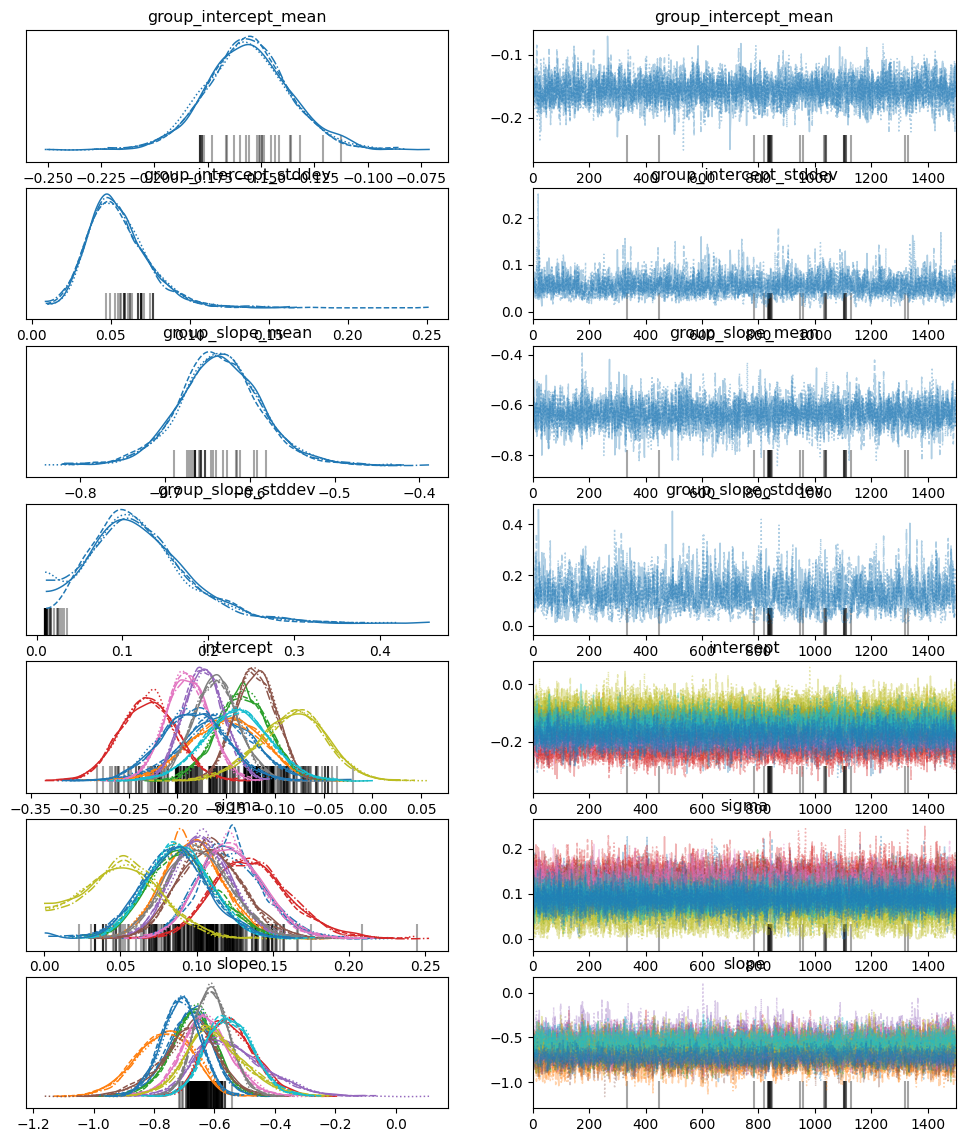

In [90]:
# Print summary statistics
print( az.summary(trace_hierarch) )#, var_names=['intercept', 'slope', 'sigma']))

az.plot_trace( trace_hierarch )